<a href="https://colab.research.google.com/github/ndb796/Deep-Learning-Paper-Review-and-Practice/blob/master/code_practices/Sign_OPT_Attack_for_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Load Required Libraries</b>

In [ ]:
!git clone https://github.com/ndb796/attackbox

Cloning into 'attackbox'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 594 (delta 7), reused 14 (delta 6), pack-reused 575
Receiving objects: 100% (594/594), 74.55 MiB | 20.14 MiB/s, done.
Resolving deltas: 100% (298/298), done.
Checking out files: 100% (191/191), done.


In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision

import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

import os
import time
import shutil

#### <b>Load Dataset</b>

In [ ]:
def load_model(model, filename):
    """ Load the training model """
    model.load_state_dict(torch.load(filename))


def load_cifar10_data(batch_size=1):
    """ Load MNIST data from torchvision.datasets 
        input: None
        output: minibatches of train and test sets 
    """
    # CIFAR10 Dataset
    train_dataset = torchvision.datasets.CIFAR10('./data/cifar10-py', download=True, train=True, transform=torchvision.transforms.ToTensor())
    test_dataset = torchvision.datasets.CIFAR10('./data/cifar10-py', download=True, train=False, transform=torchvision.transforms.ToTensor())

    # Data Loader (Input Pipeline)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, train_dataset, test_dataset


test_batch_size = 1
train_loader, test_loader, train_dataset, test_dataset = load_cifar10_data(test_batch_size)

Files already downloaded and verified
Files already downloaded and verified


#### <b>Load Pre-trained Classification Model</b>

In [ ]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class VGG_plain(nn.Module):
    def __init__(self, vgg_name, nclass, img_width=32):
        super(VGG_plain, self).__init__()
        self.img_width = img_width
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, nclass)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        width = self.img_width
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                width = width // 2
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=width, stride=1)]
        return nn.Sequential(*layers)

    def predict(self, image):
        self.eval()
        image = torch.clamp(image,0,1)
        image = Variable(image, volatile=True).view(1,3, 32,32)
        if torch.cuda.is_available():
            image = image.cuda()
        output = self(image)[0]
        print(output)
        _, predict = torch.max(output.data, 1)
        return predict[0]
    
    def predict_batch(self, image):
        self.eval()
        image = torch.clamp(image,0,1)
        image = Variable(image, volatile=True)
        if torch.cuda.is_available():
            image = image.cuda()
        output = self(image)[0]
        _, predict = torch.max(output.data, 1)
        return predict


def vgg16():
    return VGG_plain('VGG16', nclass=10)


model_dir = 'attackbox/model/cifar10_vgg_plain.pth'
net = vgg16()
net = torch.nn.DataParallel(net, device_ids=[0])
load_model(net, model_dir)
net.cuda()
net.eval()

DataParallel(
  (module): VGG_plain(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, pad

In [ ]:
class PytorchModel(object):
    def __init__(self,model, bounds, num_classes):
        self.model = model
        self.model.eval()
        self.bounds = bounds
        self.num_classes = num_classes
        self.num_queries = 0

    def predict(self,image):
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        output = self.model(image)
        self.num_queries += 1
        return output
 
    def predict_prob(self,image):
        with torch.no_grad():
            image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
            if len(image.size())!=4:
                image = image.unsqueeze(0)
            output = self.model(image)
            self.num_queries += image.size(0)
        return output

    def predict_label(self, image, batch=False):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            self.num_queries += image.size(0)
        _, predict = torch.max(output.data, 1)
        if batch:
            return predict
        else:
            return predict[0]

    def predict_ensemble(self, image):
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).type(torch.FloatTensor)
        image = torch.clamp(image,self.bounds[0],self.bounds[1]).cuda()
        if len(image.size())!=4:
            image = image.unsqueeze(0)
        with torch.no_grad():
            output = self.model(image)
            output.zero_()
            for i in range(10):
                output += self.model(image)
                self.num_queries += image.size(0)

        _, predict = torch.max(output.data, 1)

        return predict[0]

    def get_num_queries(self):
        return self.num_queries

    def get_gradient(self,loss):
        loss.backward()

#### <b>Adversarial Attack</b>

In [ ]:
start_learning_rate = 1.0
MAX_ITER = 1000


def quad_solver(Q, b):
    """
    Solve min_a  0.5*aQa + b^T a s.t. a>=0
    """
    K = Q.shape[0]
    alpha = np.zeros((K,))
    g = b
    Qdiag = np.diag(Q)
    for i in range(20000):
        delta = np.maximum(alpha - g / Qdiag, 0) - alpha
        idx = np.argmax(abs(delta))
        val = delta[idx]
        if abs(val) < 1e-7: 
            break
        g = g + val * Q[:,idx]
        alpha[idx] += val
    return alpha


def sign(y):
    """
    y -- numpy array of shape (m,)
    Returns an element-wise indication of the sign of a number.
    The sign function returns -1 if y < 0, 1 if x >= 0. nan is returned for nan inputs.
    """
    y_sign = np.sign(y)
    y_sign[y_sign==0] = 1
    return y_sign


class OPT_attack_sign_SGD(object):
    def __init__(self, model, k=200, train_dataset=None):
        self.model = model
        self.k = k
        self.train_dataset = train_dataset 
        self.log = torch.ones(MAX_ITER, 2)

    def get_log(self):
        return self.log

    def attack_untargeted(self, x0, y0, alpha = 0.2, beta = 0.001, iterations = 1000, query_limit=20000,
                          distortion=None, svm=False, momentum=0.0, stopping=0.0001):
        """ Attack the original image and return adversarial example
            model: (pytorch model)
            train_dataset: set of training data
            (x0, y0): original image
        """
        model = self.model
        y0 = y0[0]
        query_count = 0
        ls_total = 0

        if (model.predict_label(x0) != y0):
            print("Fail to classify the image. No need to attack.")
            return x0, 0, True, 0, None

        # 공격을 위한 초기 방향(initial direction) theta 찾기 / g_theta: 거리(짧을수록 좋음)
        # init: Calculate a good starting point (direction)
        num_directions = 100
        best_theta, g_theta = None, float('inf')
        print("Searching for the initial direction on %d random directions: " % (num_directions))
        timestart = time.time()
        for i in range(num_directions):
            query_count += 1
            theta = np.random.randn(*x0.shape) # gaussian distortion
            # register adv directions
            if model.predict_label(x0 + torch.tensor(theta, dtype=torch.float).cuda()) != y0: 
                initial_lbd = LA.norm(theta)
                theta /= initial_lbd # l2 normalize
                lbd, count = self.fine_grained_binary_search(model, x0, y0, theta, initial_lbd, g_theta)
                query_count += count
                if lbd < g_theta:
                    best_theta, g_theta = theta, lbd
                    print("--------> Found distortion %.4f" % g_theta)
        timeend = time.time()
        
        # fail if cannot find a adv direction within 200 Gaussian
        if g_theta == float('inf'):
            print("Couldn't find valid initial, failed")
            return x0, 0, False, query_count, best_theta
        print("==========> Found best distortion %.4f in %.4f seconds "
              "using %d queries" % (g_theta, timeend-timestart, query_count))
        self.log[0][0], self.log[0][1] = g_theta, query_count

        # 반복적으로 theta를 업데이트하며 공격 수행
        # Begin Gradient Descent.
        timestart = time.time()
        xg, gg = best_theta, g_theta
        vg = np.zeros_like(xg)
        learning_rate = start_learning_rate
        prev_obj = 100000
        distortions = [gg]
        for i in range(iterations):
            # 기울기(gradient) 예측
            # gradient estimation at x0 + theta (init)
            if svm == True:
                sign_gradient, grad_queries = self.sign_grad_svm(x0, y0, xg, initial_lbd=gg, h=beta)
            else:
                sign_gradient, grad_queries = self.sign_grad_v1(x0, y0, xg, initial_lbd=gg, h=beta)

            # Line search of the step size of gradient descent
            ls_count = 0
            min_theta = xg # next theta
            min_g2 = gg # current g_theta
            min_vg = vg # velocity (for momentum only)
            for _ in range(15):
                # update theta by one step sgd
                if momentum > 0:
                    new_vg = momentum * vg - alpha*sign_gradient
                    new_theta = xg + new_vg
                else:
                    new_theta = xg - alpha * sign_gradient
                new_theta /= LA.norm(new_theta)

                new_g2, count = self.fine_grained_binary_search_local(
                    model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                ls_count += count
                alpha = alpha * 2 # gradually increasing step size
                if new_g2 < min_g2:
                    min_theta = new_theta
                    min_g2 = new_g2
                    if momentum > 0:
                        min_vg = new_vg
                else:
                    break

            if min_g2 >= gg: # if the above code failed for the init alpha, we then try to decrease alpha
                for _ in range(15):
                    alpha = alpha * 0.25
                    if momentum > 0:
                        new_vg = momentum * vg - alpha * sign_gradient
                        new_theta = xg + new_vg
                    else:
                        new_theta = xg - alpha * sign_gradient
                    new_theta /= LA.norm(new_theta)
                    new_g2, count = self.fine_grained_binary_search_local(
                        model, x0, y0, new_theta, initial_lbd = min_g2, tol=beta/500)
                    ls_count += count
                    if new_g2 < gg:
                        min_theta = new_theta 
                        min_g2 = new_g2
                        if momentum > 0:
                            min_vg = new_vg
                        break

            if alpha < 1e-4: # if the above two blocks of code failed
                alpha = 1.0
                print("Warning: not moving")
                beta = beta * 0.1
                if (beta < 1e-8):
                    break
            
            # if all attemps failed, min_theta, min_g2 will be the current theta (i.e. not moving)
            xg, gg = min_theta, min_g2
            vg = min_vg

            query_count += (grad_queries + ls_count)
            ls_total += ls_count
            distortions.append(gg)

            if query_count > query_limit:
                break

            # 공격이 진행되는 상황에서 로깅(logging)
            if (i + 1) % 10 == 0:
                print("Iteration %3d distortion %.4f num_queries %d" % (i+1, gg, query_count))
            self.log[i + 1][0], self.log[i + 1][1] = gg, query_count

            if (i + 1) % 30 == 0:
                # 화면에 이미지 출력하기
                img = x0.cpu() + torch.tensor(gg * xg, dtype=torch.float) # [batch_size, 1, H, W]
                img = torch.clamp(img, min=0, max=1).squeeze(0) # [1, H, W]
                img = torchvision.transforms.ToPILImage()(img)
                plt.imshow(img)
                plt.show()

        if distortion is None or gg < distortion:
            target = model.predict_label(x0 + torch.tensor(gg * xg, dtype=torch.float).cuda())
            print("Succeed distortion {:.4f} target"
                  " {:d} queries {:d} LS queries {:d}\n".format(gg, target, query_count, ls_total))
            return x0 + torch.tensor(gg * xg, dtype=torch.float).cuda(), gg, True, query_count, xg

        timeend = time.time()
        print("\nFailed: distortion %.4f" % (gg))
        
        self.log[i+1:,0] = gg
        self.log[i+1:,1] = query_count
        return x0 + torch.tensor(gg * xg, dtype=torch.float).cuda(), gg, False, query_count, xg


    def sign_grad_v1(self, x0, y0, theta, initial_lbd, h=0.001, D=4, target=None):
        """
        Evaluate the sign of gradient by formulat
        sign(g) = 1/Q [ \sum_{q=1}^Q sign( g(theta+h*u_i) - g(theta) )u_i$ ]
        """
        K = self.k # 200 random directions (for estimating the gradient)
        sign_grad = np.zeros(theta.shape)
        queries = 0

        for iii in range(K): # for each u
            u = np.random.randn(*theta.shape); u /= LA.norm(u)
            new_theta = theta + h * u; new_theta /= LA.norm(new_theta)
            sign = 1
            
            # Targeted case
            if (target is not None and 
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) == target):
                sign = -1

            # Untargeted case
            if (target is None and
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) != y0): # success
                sign = -1

            queries += 1
            sign_grad += u*sign
        
        sign_grad /= K
        
        return sign_grad, queries


    def sign_grad_svm(self, x0, y0, theta, initial_lbd, h=0.001, K=100, lr=5.0, target=None):
        """
        Evaluate the sign of gradient by formulat
        sign(g) = 1/Q [ \sum_{q=1}^Q sign( g(theta+h*u_i) - g(theta) )u_i$ ]
        """
        sign_grad = np.zeros(theta.shape)
        queries = 0
        dim = np.prod(theta.shape)
        X = np.zeros((dim, K))
        for iii in range(K):
            u = np.random.randn(*theta.shape)
            u /= LA.norm(u)
            
            sign = 1
            new_theta = theta + h * u
            new_theta /= LA.norm(new_theta)            
            
            # Targeted case
            if (target is not None and 
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) == target):
                sign = -1
                
            # Untargeted case
            if (target is None and
                self.model.predict_label(x0 + torch.tensor(initial_lbd * new_theta, dtype=torch.float).cuda()) != y0):
                sign = -1
                
            queries += 1
            X[:,iii] = sign * u.reshape((dim,))
        
        Q = X.transpose().dot(X)
        q = -1 * np.ones((K,))
        G = np.diag(-1 * np.ones((K,)))
        h = np.zeros((K,))
        alpha = quad_solver(Q, q)
        sign_grad = (X.dot(alpha)).reshape(theta.shape)
        
        return sign_grad, queries


    def fine_grained_binary_search_local(self, model, x0, y0, theta, initial_lbd = 1.0, tol=1e-5):
        nquery = 0
        lbd = initial_lbd
         
        # still inside boundary
        if model.predict_label(x0 + torch.tensor(lbd * theta, dtype=torch.float).cuda()) == y0:
            lbd_lo = lbd
            lbd_hi = lbd * 1.01
            nquery += 1
            while model.predict_label(x0 + torch.tensor(lbd_hi * theta, dtype=torch.float).cuda()) == y0:
                lbd_hi = lbd_hi * 1.01
                nquery += 1
                if lbd_hi > 20:
                    return float('inf'), nquery
        else:
            lbd_hi = lbd
            lbd_lo = lbd * 0.99
            nquery += 1
            while model.predict_label(x0 + torch.tensor(lbd_lo * theta, dtype=torch.float).cuda()) != y0 :
                lbd_lo = lbd_lo * 0.99
                nquery += 1

        while (lbd_hi - lbd_lo) > tol:
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + torch.tensor(lbd_mid * theta, dtype=torch.float).cuda()) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery


    def fine_grained_binary_search(self, model, x0, y0, theta, initial_lbd, current_best):
        nquery = 0
        if initial_lbd > current_best: 
            if model.predict_label(x0 + torch.tensor(current_best * theta, dtype=torch.float).cuda()) == y0:
                nquery += 1
                return float('inf'), nquery
            lbd = current_best
        else:
            lbd = initial_lbd

        lbd_hi = lbd
        lbd_lo = 0.0
        
        while (lbd_hi - lbd_lo) > 1e-3: # was 1e-5
            lbd_mid = (lbd_lo + lbd_hi) / 2.0
            nquery += 1
            if model.predict_label(x0 + torch.tensor(lbd_mid*theta, dtype=torch.float).cuda()) != y0:
                lbd_hi = lbd_mid
            else:
                lbd_lo = lbd_mid
        return lbd_hi, nquery


    def __call__(self, input_xi, label_or_target, targeted=False, distortion=None, seed=None,
                 svm=False, query_limit=4000, momentum=0.0, stopping=0.0001, args=None):
        if targeted:
            raise NotImplementedError
        else:
            adv = self.attack_untargeted(input_xi, label_or_target, distortion=distortion,
                                         svm=svm, query_limit=query_limit, momentum=momentum,
                                         stopping=stopping)
        return adv

In [ ]:
# 단순히 p-norm 거리(distance) 계산
def distance(x_adv, x, norm='l2'):
    diff = (x_adv - x).view(x.size(0), -1)
    if norm == 'l2':
        out = torch.sqrt(torch.sum(diff * diff)).item()
        return out
    elif norm == 'linf':
        out = torch.sum(torch.max(torch.abs(diff), 1)[0]).item()
        return out

In [ ]:
from types import SimpleNamespace

args = SimpleNamespace()

args.targeted = False # Targeted attack.
args.random_start = False # PGD attack with random start.
args.epsilon = 0.5
args.seed = 123
args.norm = 'l2'
args.test_batch = 20 # The number of test batch.
args.query = 20000

image batch: 0
Searching for the initial direction on 100 random directions: 
--------> Found distortion 4.3546
--------> Found distortion 3.0316
--------> Found distortion 2.9102
--------> Found distortion 2.7461
--------> Found distortion 2.5174
==========> Found best distortion 2.5174 in 2.8204 seconds using 260 queries
Iteration  10 distortion 0.5238 num_queries 3116
Iteration  20 distortion 0.3482 num_queries 5682
Iteration  30 distortion 0.2880 num_queries 8146


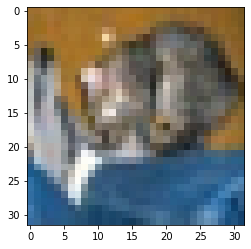

Iteration  40 distortion 0.2598 num_queries 10546
Iteration  50 distortion 0.2455 num_queries 12905
Iteration  60 distortion 0.2334 num_queries 15272


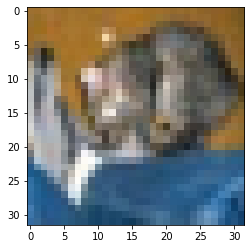

Iteration  70 distortion 0.2251 num_queries 17582
Iteration  80 distortion 0.2207 num_queries 19880
Succeed distortion 0.2201 target 6 queries 20128 LS queries 3668



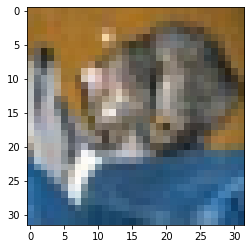

image batch: 1
Searching for the initial direction on 100 random directions: 
--------> Found distortion 4.7415
--------> Found distortion 4.2669
--------> Found distortion 3.4444
--------> Found distortion 3.3528
--------> Found distortion 3.3429
==========> Found best distortion 3.3429 in 2.6915 seconds using 261 queries
Iteration  10 distortion 0.4706 num_queries 3327
Iteration  20 distortion 0.3058 num_queries 6001
Iteration  30 distortion 0.2492 num_queries 8543


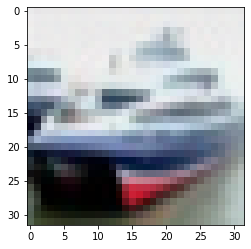

Iteration  40 distortion 0.2250 num_queries 10942
Iteration  50 distortion 0.2114 num_queries 13283
Iteration  60 distortion 0.2022 num_queries 15583


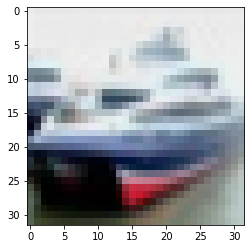

Iteration  70 distortion 0.1962 num_queries 17876
Succeed distortion 0.1931 target 1 queries 20126 LS queries 3865



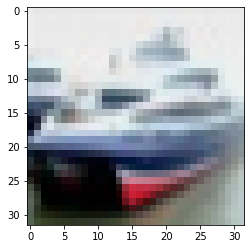

image batch: 2
Searching for the initial direction on 100 random directions: 
--------> Found distortion 1.6381
--------> Found distortion 1.4381
--------> Found distortion 1.1839
==========> Found best distortion 1.1839 in 2.3955 seconds using 235 queries
Iteration  10 distortion 0.2588 num_queries 3039
Iteration  20 distortion 0.1787 num_queries 5573
Iteration  30 distortion 0.1497 num_queries 7978


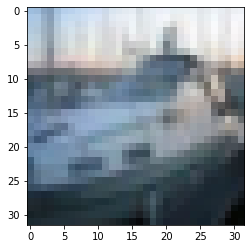

Iteration  40 distortion 0.1372 num_queries 10321
Iteration  50 distortion 0.1296 num_queries 12693
Iteration  60 distortion 0.1243 num_queries 15013


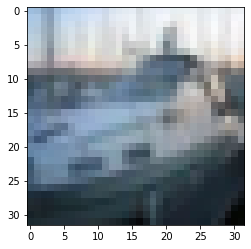

Iteration  70 distortion 0.1202 num_queries 17302
Iteration  80 distortion 0.1180 num_queries 19588
Succeed distortion 0.1179 target 9 queries 20060 LS queries 3425



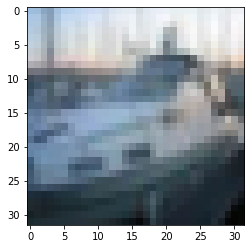

image batch: 3
Searching for the initial direction on 100 random directions: 
--------> Found distortion 1.2552
--------> Found distortion 1.0101
==========> Found best distortion 1.0101 in 2.2787 seconds using 225 queries
Iteration  10 distortion 0.2300 num_queries 3006
Iteration  20 distortion 0.1557 num_queries 5544
Iteration  30 distortion 0.1316 num_queries 7969


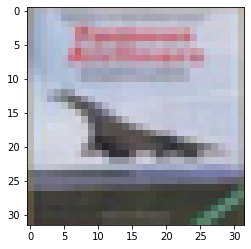

Iteration  40 distortion 0.1210 num_queries 10342
Iteration  50 distortion 0.1156 num_queries 12665
Iteration  60 distortion 0.1107 num_queries 14994


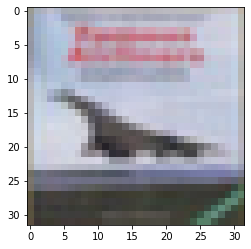

Iteration  70 distortion 0.1074 num_queries 17278
Iteration  80 distortion 0.1056 num_queries 19581
Succeed distortion 0.1054 target 8 queries 20049 LS queries 3424



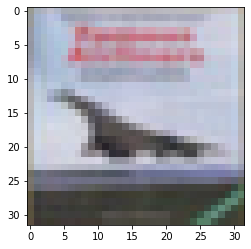

image batch: 4
Searching for the initial direction on 100 random directions: 
--------> Found distortion 45.5305
--------> Found distortion 16.1069
--------> Found distortion 13.4093
--------> Found distortion 11.3779
--------> Found distortion 6.6542
==========> Found best distortion 6.6542 in 2.6242 seconds using 255 queries
Iteration  10 distortion 0.3757 num_queries 3231
Iteration  20 distortion 0.2306 num_queries 5818
Iteration  30 distortion 0.1912 num_queries 8316


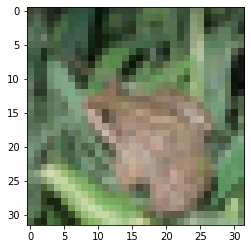

Iteration  40 distortion 0.1737 num_queries 10651
Iteration  50 distortion 0.1631 num_queries 12967
Iteration  60 distortion 0.1567 num_queries 15309


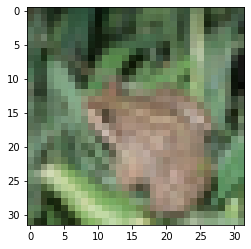

Iteration  70 distortion 0.1521 num_queries 17604
Iteration  80 distortion 0.1493 num_queries 19885
Succeed distortion 0.1490 target 4 queries 20107 LS queries 3652



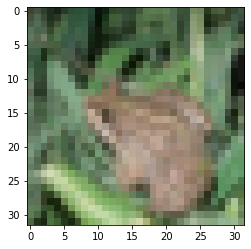

image batch: 5
Searching for the initial direction on 100 random directions: 
--------> Found distortion 36.1182
--------> Found distortion 19.8745
--------> Found distortion 13.0996
==========> Found best distortion 13.0996 in 2.2519 seconds using 220 queries
Iteration  10 distortion 0.4348 num_queries 3909
Iteration  20 distortion 0.0859 num_queries 6609
Iteration  30 distortion 0.0651 num_queries 9074


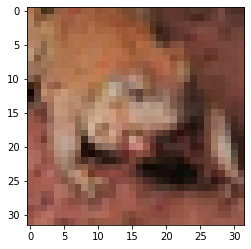

Iteration  40 distortion 0.0568 num_queries 11412
Iteration  50 distortion 0.0527 num_queries 13730
Iteration  60 distortion 0.0509 num_queries 16075


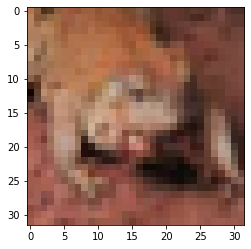

Iteration  70 distortion 0.0500 num_queries 18551
Succeed distortion 0.0491 target 3 queries 20011 LS queries 4591



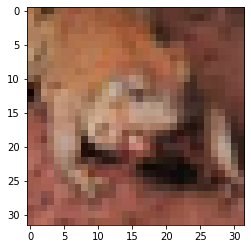

image batch: 6
Searching for the initial direction on 100 random directions: 
--------> Found distortion 5.3892
--------> Found distortion 4.5866
--------> Found distortion 4.1045
--------> Found distortion 4.0955
--------> Found distortion 3.7916
--------> Found distortion 3.7656
--------> Found distortion 3.7408
--------> Found distortion 3.4075
--------> Found distortion 3.3750
--------> Found distortion 3.1583
--------> Found distortion 2.9193
--------> Found distortion 2.7119
==========> Found best distortion 2.7119 in 3.5634 seconds using 339 queries
Iteration  10 distortion 0.4783 num_queries 3179
Iteration  20 distortion 0.3046 num_queries 5730
Iteration  30 distortion 0.2518 num_queries 8188


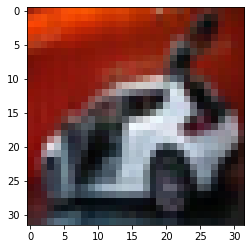

Iteration  40 distortion 0.2305 num_queries 10545
Iteration  50 distortion 0.2174 num_queries 12940
Iteration  60 distortion 0.2070 num_queries 15292


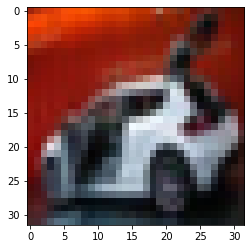

Iteration  70 distortion 0.2024 num_queries 17598
Iteration  80 distortion 0.1984 num_queries 19868
Succeed distortion 0.1983 target 9 queries 20105 LS queries 3566



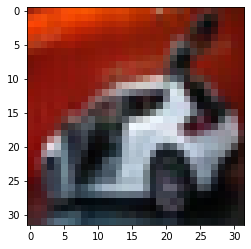

image batch: 7
Searching for the initial direction on 100 random directions: 
--------> Found distortion 17.5573
--------> Found distortion 12.0032
--------> Found distortion 11.8691
--------> Found distortion 11.8582
==========> Found best distortion 11.8582 in 2.4418 seconds using 237 queries
Iteration  10 distortion 0.5487 num_queries 3203
Iteration  20 distortion 0.2097 num_queries 5941
Iteration  30 distortion 0.1579 num_queries 8393


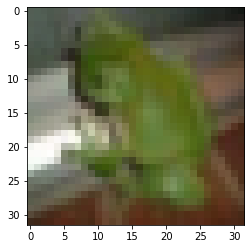

Iteration  40 distortion 0.1385 num_queries 10781
Iteration  50 distortion 0.1288 num_queries 13170
Iteration  60 distortion 0.1218 num_queries 15531


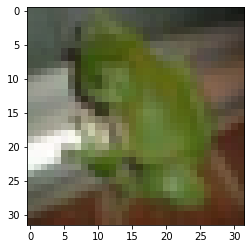

Iteration  70 distortion 0.1177 num_queries 17833
Succeed distortion 0.1148 target 3 queries 20109 LS queries 3872



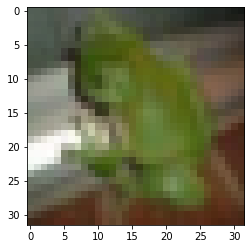

image batch: 8
Searching for the initial direction on 100 random directions: 
--------> Found distortion 2.7662
--------> Found distortion 2.4056
--------> Found distortion 2.2235
--------> Found distortion 2.0248
--------> Found distortion 2.0189
==========> Found best distortion 2.0189 in 2.6418 seconds using 258 queries
Iteration  10 distortion 0.4267 num_queries 2999
Iteration  20 distortion 0.2861 num_queries 5562
Iteration  30 distortion 0.2402 num_queries 8007


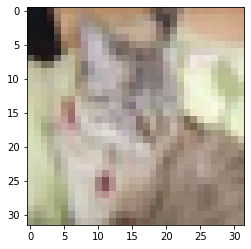

Iteration  40 distortion 0.2183 num_queries 10402
Iteration  50 distortion 0.2034 num_queries 12766
Iteration  60 distortion 0.1951 num_queries 15100


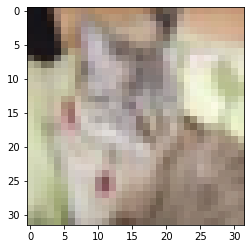

Iteration  70 distortion 0.1898 num_queries 17381
Iteration  80 distortion 0.1868 num_queries 19668
Succeed distortion 0.1863 target 6 queries 20114 LS queries 3456



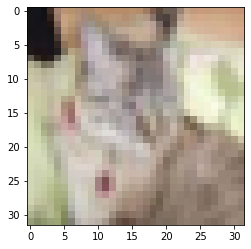

image batch: 9
Searching for the initial direction on 100 random directions: 
--------> Found distortion 2.3112
--------> Found distortion 2.2683
--------> Found distortion 2.0501
--------> Found distortion 2.0046
--------> Found distortion 1.6973
==========> Found best distortion 1.6973 in 2.6514 seconds using 258 queries
Iteration  10 distortion 0.4277 num_queries 2946
Iteration  20 distortion 0.2758 num_queries 5603
Iteration  30 distortion 0.2300 num_queries 8112


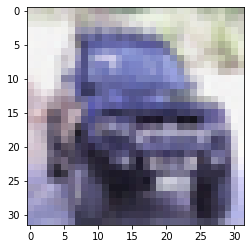

Iteration  40 distortion 0.2082 num_queries 10464
Iteration  50 distortion 0.1947 num_queries 12803
Iteration  60 distortion 0.1859 num_queries 15135


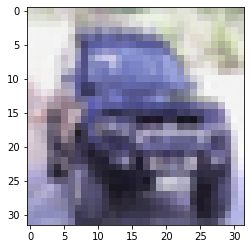

Iteration  70 distortion 0.1810 num_queries 17436
Iteration  80 distortion 0.1772 num_queries 19752
Succeed distortion 0.1769 target 6 queries 20209 LS queries 3551



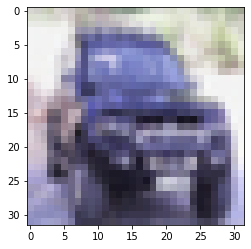

image batch: 10
Searching for the initial direction on 100 random directions: 
--------> Found distortion 1.8646
--------> Found distortion 1.7071
--------> Found distortion 1.5587
--------> Found distortion 1.4811
==========> Found best distortion 1.4811 in 2.5018 seconds using 245 queries
Iteration  10 distortion 0.2857 num_queries 3128
Iteration  20 distortion 0.1661 num_queries 5662
Iteration  30 distortion 0.1356 num_queries 8154


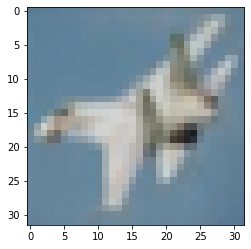

Iteration  40 distortion 0.1225 num_queries 10493
Iteration  50 distortion 0.1149 num_queries 12863
Iteration  60 distortion 0.1099 num_queries 15154


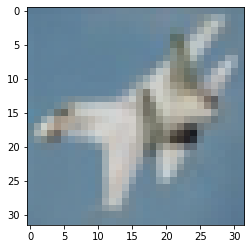

Iteration  70 distortion 0.1063 num_queries 17468
Iteration  80 distortion 0.1037 num_queries 19741
Succeed distortion 0.1034 target 5 queries 20210 LS queries 3565



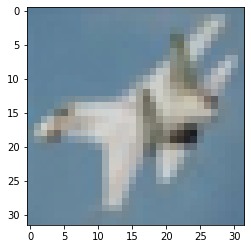

image batch: 11
Searching for the initial direction on 100 random directions: 
--------> Found distortion 5.2306
--------> Found distortion 4.9305
--------> Found distortion 4.5399
==========> Found best distortion 4.5399 in 2.4279 seconds using 239 queries
Iteration  10 distortion 1.2756 num_queries 3066
Iteration  20 distortion 0.8885 num_queries 5655
Iteration  30 distortion 0.7281 num_queries 8192


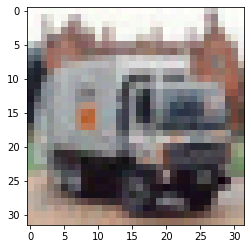

Iteration  40 distortion 0.6596 num_queries 10584
Iteration  50 distortion 0.6157 num_queries 12982
Iteration  60 distortion 0.5834 num_queries 15381


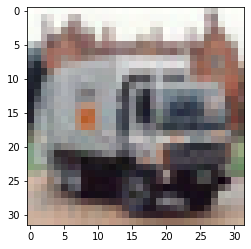

Iteration  70 distortion 0.5636 num_queries 17719

Failed: distortion 0.5512


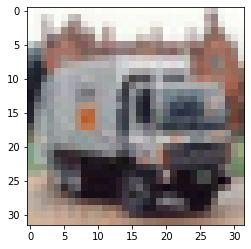

image batch: 12
Searching for the initial direction on 100 random directions: 
--------> Found distortion 1.5752
--------> Found distortion 1.2898
--------> Found distortion 1.1248
--------> Found distortion 0.9397
--------> Found distortion 0.7663
==========> Found best distortion 0.7663 in 2.6340 seconds using 254 queries
Iteration  10 distortion 0.1060 num_queries 3039
Iteration  20 distortion 0.0709 num_queries 5610
Iteration  30 distortion 0.0604 num_queries 7938


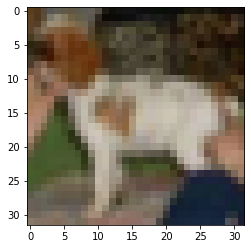

Iteration  40 distortion 0.0555 num_queries 10243
Iteration  50 distortion 0.0525 num_queries 12540
Iteration  60 distortion 0.0506 num_queries 14840


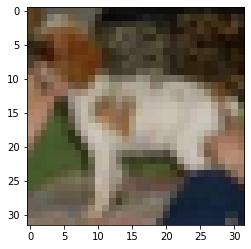

Iteration  70 distortion 0.0501 num_queries 17437
Iteration  80 distortion 0.0492 num_queries 19868
Succeed distortion 0.0492 target 4 queries 20094 LS queries 3640



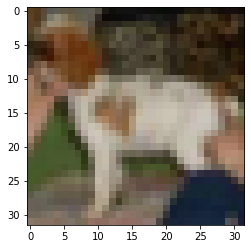

image batch: 13
Searching for the initial direction on 100 random directions: 
--------> Found distortion 4.6099
--------> Found distortion 3.3010
==========> Found best distortion 3.3010 in 2.3114 seconds using 227 queries
Iteration  10 distortion 0.7701 num_queries 3091
Iteration  20 distortion 0.5121 num_queries 5669
Iteration  30 distortion 0.4143 num_queries 8251


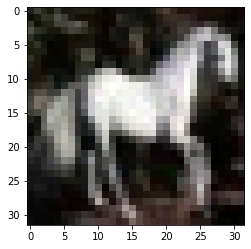

Iteration  40 distortion 0.3746 num_queries 10625
Iteration  50 distortion 0.3536 num_queries 13040
Iteration  60 distortion 0.3366 num_queries 15447


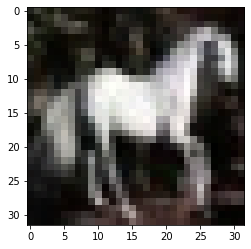

Iteration  70 distortion 0.3266 num_queries 17773
Succeed distortion 0.3198 target 6 queries 20046 LS queries 3819



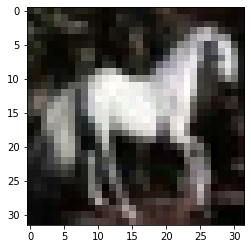

image batch: 14
Searching for the initial direction on 100 random directions: 
--------> Found distortion 4.4494
--------> Found distortion 3.9155
--------> Found distortion 3.3046
==========> Found best distortion 3.3046 in 2.4470 seconds using 238 queries
Iteration  10 distortion 0.8499 num_queries 3070
Iteration  20 distortion 0.4501 num_queries 5697
Iteration  30 distortion 0.3652 num_queries 8192


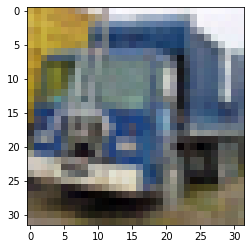

Iteration  40 distortion 0.3217 num_queries 10551
Iteration  50 distortion 0.3024 num_queries 12961
Iteration  60 distortion 0.2857 num_queries 15355


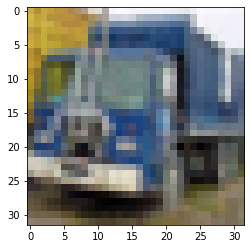

Iteration  70 distortion 0.2764 num_queries 17678
Iteration  80 distortion 0.2703 num_queries 19976
Succeed distortion 0.2699 target 8 queries 20202 LS queries 3764



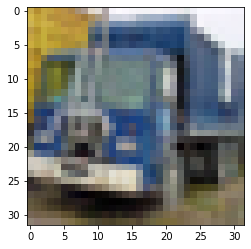

image batch: 15
Searching for the initial direction on 100 random directions: 
--------> Found distortion 5.1076
--------> Found distortion 4.0314
--------> Found distortion 3.7263
--------> Found distortion 3.3133
--------> Found distortion 2.9816
==========> Found best distortion 2.9816 in 2.6866 seconds using 260 queries
Iteration  10 distortion 0.1626 num_queries 3308
Iteration  20 distortion 0.0946 num_queries 5819
Iteration  30 distortion 0.0781 num_queries 8252


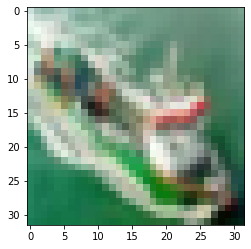

Iteration  40 distortion 0.0722 num_queries 10570
Iteration  50 distortion 0.0674 num_queries 12905
Iteration  60 distortion 0.0645 num_queries 15174


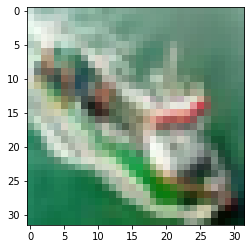

Iteration  70 distortion 0.0629 num_queries 17480
Iteration  80 distortion 0.0615 num_queries 19758
Succeed distortion 0.0614 target 6 queries 20220 LS queries 3560



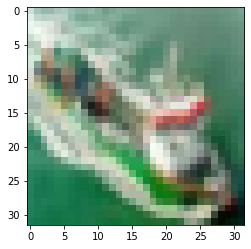

image batch: 16
Searching for the initial direction on 100 random directions: 
--------> Found distortion 3.1759
--------> Found distortion 2.3486
--------> Found distortion 2.3457
--------> Found distortion 2.2553
--------> Found distortion 2.0741
--------> Found distortion 2.0402
--------> Found distortion 1.9794
--------> Found distortion 1.8364
==========> Found best distortion 1.8364 in 3.0387 seconds using 290 queries
Iteration  10 distortion 0.4081 num_queries 3178
Iteration  20 distortion 0.2790 num_queries 5707
Iteration  30 distortion 0.2325 num_queries 8198


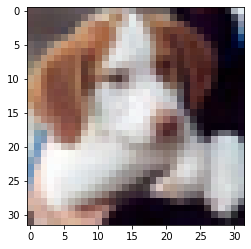

Iteration  40 distortion 0.2126 num_queries 10548
Iteration  50 distortion 0.2011 num_queries 12936
Iteration  60 distortion 0.1923 num_queries 15270


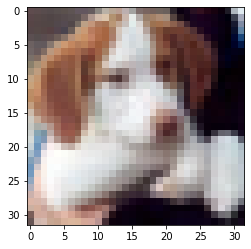

Iteration  70 distortion 0.1870 num_queries 17539
Iteration  80 distortion 0.1829 num_queries 19843
Succeed distortion 0.1824 target 3 queries 20076 LS queries 3586



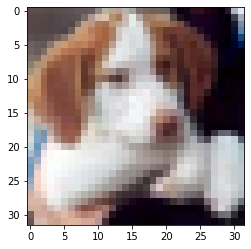

image batch: 17
Searching for the initial direction on 100 random directions: 
--------> Found distortion 3.3154
--------> Found distortion 2.9592
--------> Found distortion 2.7642
--------> Found distortion 2.6346
==========> Found best distortion 2.6346 in 2.5690 seconds using 248 queries
Iteration  10 distortion 0.7947 num_queries 3053
Iteration  20 distortion 0.5043 num_queries 5714
Iteration  30 distortion 0.4066 num_queries 8243


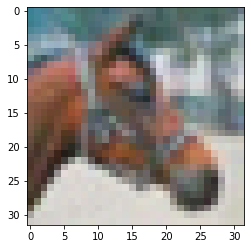

Iteration  40 distortion 0.3592 num_queries 10648
Iteration  50 distortion 0.3359 num_queries 13026
Iteration  60 distortion 0.3166 num_queries 15444


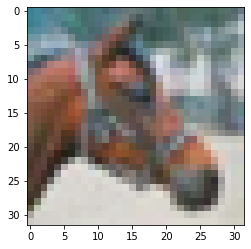

Iteration  70 distortion 0.3055 num_queries 17775
Succeed distortion 0.2988 target 4 queries 20071 LS queries 3823



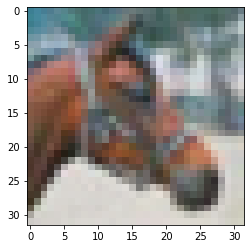

image batch: 18
Searching for the initial direction on 100 random directions: 
--------> Found distortion 3.4631
--------> Found distortion 3.4505
--------> Found distortion 3.2685
==========> Found best distortion 3.2685 in 2.4372 seconds using 237 queries
Iteration  10 distortion 0.9632 num_queries 3125
Iteration  20 distortion 0.6208 num_queries 5744
Iteration  30 distortion 0.4975 num_queries 8215


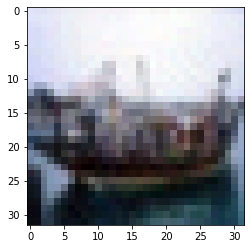

Iteration  40 distortion 0.4429 num_queries 10607
Iteration  50 distortion 0.4154 num_queries 13052
Iteration  60 distortion 0.3908 num_queries 15454


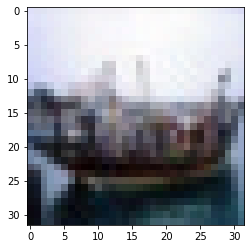

Iteration  70 distortion 0.3755 num_queries 17792
Succeed distortion 0.3651 target 6 queries 20117 LS queries 3880



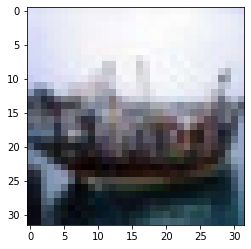

image batch: 19
Searching for the initial direction on 100 random directions: 
--------> Found distortion 21.5133
--------> Found distortion 19.9324
--------> Found distortion 14.0204
--------> Found distortion 12.8130
--------> Found distortion 10.0172
==========> Found best distortion 10.0172 in 2.5876 seconds using 249 queries
Iteration  10 distortion 0.7309 num_queries 3566
Iteration  20 distortion 0.3454 num_queries 6237
Iteration  30 distortion 0.2710 num_queries 8785


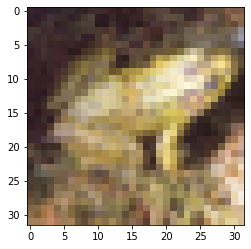

Iteration  40 distortion 0.2398 num_queries 11169
Iteration  50 distortion 0.2242 num_queries 13550
Iteration  60 distortion 0.2132 num_queries 15937


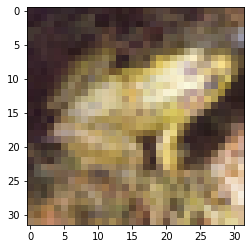

Iteration  70 distortion 0.2069 num_queries 18229
Succeed distortion 0.2034 target 2 queries 20074 LS queries 4225



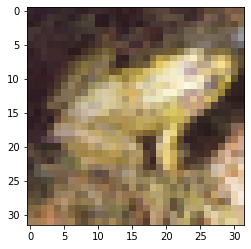

image batch: 20
clean count: 20
acc under attack count: 0
avg total queries used: 406371
avg stop queries used: 20112.0
average distortion: 0.19576918184757233
robust accuracy: 0.050000000000000044


In [ ]:
amodel = PytorchModel(net, bounds=[0, 1], num_classes=10)
attack = OPT_attack_sign_SGD(amodel)

total_r_count = 0
total_clean_count = 0
total_distance = 0
successes = []
stop_queries = []

for i, (xi, yi) in enumerate(test_loader):
    print(f"image batch: {i}")
    if i == args.test_batch:
        break

    xi, yi = xi.cuda(), yi.cuda()
    adv, distortion, is_success, nqueries, theta_signopt = attack(xi, yi, targeted=args.targeted, query_limit=args.query, distortion=args.epsilon, args=args)

    # 결과 출력(l_2 distortion이 충분히 감소했을 때 성공)
    img = torchvision.transforms.ToPILImage()(torch.clamp(adv, min=0, max=1).squeeze(0))
    plt.imshow(img)
    plt.show()

    if is_success:
        stop_queries.append(nqueries)

    if args.targeted == False:
        r_count = (torch.max(amodel.predict(adv), 1)[1] == yi).nonzero().shape[0]
        clean_count = (torch.max(amodel.predict(xi), 1)[1] == yi).nonzero().shape[0]
        total_r_count += r_count
        total_clean_count += clean_count
        total_distance += distance(adv, xi, norm=args.norm)

    successes.append(is_success)

num_queries = amodel.get_num_queries()
print(f"clean count: {total_clean_count}")
print(f"acc under attack count: {total_r_count}")
print(f"avg total queries used: {num_queries}")
print(f"avg stop queries used: {np.mean(stop_queries)}")
print(f"average distortion: {total_distance / (args.test_batch * test_batch_size)}")
print("robust accuracy: {}".format(1 - np.mean(successes)))